In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import statistics
import matplotlib.pyplot as plt

# Load feature table

In [3]:
import sqlite3
conn = sqlite3.connect("/Users/ergangwang/Downloads/DSAH_Final/data_MIMIC/MIMIC.db")
admissions_df=pd.read_sql("""
    SELECT * FROM admissions
""",conn)
#df = pd.read_csv('/Users/ergangwang/Downloads/DSAH_Final/data_MIMIC/MIMIC.db')

In [11]:
feature_table = pd.read_csv('/Users/ergangwang/Downloads/DSAH_Final/feature_with_label_all_48H.csv')

In [4]:
#admissions_df = pd.read_csv('./data/admissions.csv')
admissions_df['HOSPITAL_EXPIRE_FLAG'].value_counts()

0    53122
1     5854
Name: HOSPITAL_EXPIRE_FLAG, dtype: int64

In [5]:
admissions_df['ADMITTIME'] = pd.to_datetime(admissions_df['ADMITTIME'])
admissions_df['DISCHTIME'] = pd.to_datetime(admissions_df['DISCHTIME'])
admissions_df['length_of_stay'] = (admissions_df['DISCHTIME'] - admissions_df['ADMITTIME']) / np.timedelta64(1, 'h')
admissions_df.dtypes

index                            int64
ROW_ID                           int64
SUBJECT_ID                       int64
HADM_ID                          int64
ADMITTIME               datetime64[ns]
DISCHTIME               datetime64[ns]
DEATHTIME                       object
ADMISSION_TYPE                  object
ADMISSION_LOCATION              object
DISCHARGE_LOCATION              object
INSURANCE                       object
LANGUAGE                        object
RELIGION                        object
MARITAL_STATUS                  object
ETHNICITY                       object
EDREGTIME                       object
EDOUTTIME                       object
DIAGNOSIS                       object
HOSPITAL_EXPIRE_FLAG             int64
HAS_CHARTEVENTS_DATA             int64
length_of_stay                 float64
dtype: object

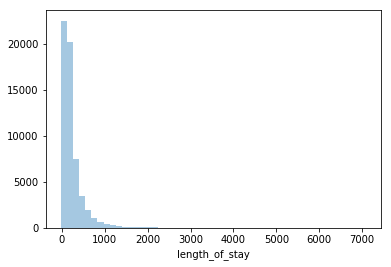

In [6]:
sns.distplot(admissions_df['length_of_stay'], kde=False)

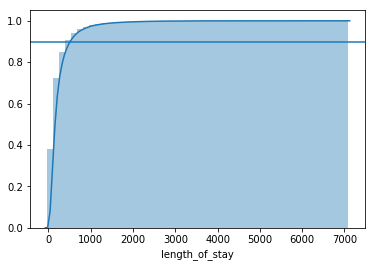

In [7]:
g = sns.distplot(admissions_df['length_of_stay'],
             hist_kws=dict(cumulative=True),
             kde_kws=dict(cumulative=True))
ax = g.axes
ax.axhline(.9)
plt.show()

### Filter out stays less than 4 hours or longer than 21 days AND patient is alive

In [8]:
patient_to_remove = ((admissions_df['length_of_stay'] > 24 * 21) & (admissions_df['HOSPITAL_EXPIRE_FLAG'] == 0)) | (admissions_df['length_of_stay'] < 4)

In [9]:
admissions_filtered_time = admissions_df[~patient_to_remove]

In [12]:
df_filtered_time = feature_table[feature_table['HADM_ID'].isin(admissions_filtered_time['HADM_ID'])]
df_filtered_time.drop(columns=['HADM_ID', 'bin_num'], inplace=True)

/Users/ergangwang/anaconda/envs/py36/lib/python3.6/site-packages/pandas/core/frame.py:3930: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [13]:
df_filtered_time.shape

(183085, 336)

### Remove Ethnicity

In [14]:
df_filtered_time = df_filtered_time.loc[:, ~df_filtered_time.columns.str.startswith('ethnicity')]

In [15]:
df_filtered_time['label'].value_counts()

0    178066
1      5019
Name: label, dtype: int64

# We see that the classes are extremely imbalanced. Two ways of dealing with imbalanced data

## 1. downsample majority class

In [16]:
from sklearn.utils import resample
df_majority = df_filtered_time[df_filtered_time.label==0]
df_minority = df_filtered_time[df_filtered_time.label==1]
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=10000,     # to match minority class
                                 random_state=123)
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
label_downsampled = df_downsampled['label'].copy()
df_downsampled.drop(columns=['label'], inplace=True)

## 2. upsample minority class

In [17]:
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=100000,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
label_upsampled = df_upsampled['label'].copy()
df_upsampled.drop(columns=['label'], inplace=True)

In [18]:
label_og = df_filtered_time['label'].copy()
df_og = df_filtered_time.drop(columns=['label'])

# Now we are ready to screen some hyperparameters
### Define methods for removing certain features

In [37]:
from sklearn.preprocessing import FunctionTransformer
abnormal_cols = df_filtered_time.columns[df_filtered_time.columns.str.startswith('abnormal')]
abnormal_ix = [
    list(df_filtered_time.columns).index(col)
    for col in abnormal_cols]
urine_ix = list(df_filtered_time.columns).index('Urine output_sum')
def urine_remover(X, remove_urine=False):
    if remove_urine:
        X = np.delete(X, urine_ix, axis=1)
    return X
def abnormal_lab_sum(X, sum_abnormal_lab=True):
    if sum_abnormal_lab:
        abnormal_labs = X[:, abnormal_ix]
        sum_abnormal = np.sum(abnormal_labs, axis=1)
        X = np.c_[X, sum_abnormal]
    return X
def remove_abnormal(X, remove_abnormal_lab=False):
    if remove_abnormal_lab:
        X = np.delete(X, abnormal_ix, axis=1)
    return X

In [38]:
from sklearn.base import BaseEstimator, TransformerMixin
class Percent_na_remover(BaseEstimator, TransformerMixin):
    def __init__(self, percent_na=.45):
        self.percent_na = percent_na
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        nanvals = np.isnan(X)
        nans_per_col = np.count_nonzero(nanvals, axis=0)
        ix_to_remove = []
        for ix, num_nans in enumerate(nans_per_col):
            if (num_nans / X.shape[0]) > self.percent_na:
                ix_to_remove.append(ix)
        X = np.delete(X, ix_to_remove, axis=1)
        return X

### Construct pipeline for prepping data

In [39]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
prep_pipeline = Pipeline([
    ('urine_remove', FunctionTransformer(urine_remover, validate=False, 
                                         kw_args={'remove_urine': False})),
    ('abnormal_sum', FunctionTransformer(abnormal_lab_sum, validate=False, 
                                         kw_args={'sum_abnormal_lab': True})),
    ('remove_abnormal_labs', FunctionTransformer(remove_abnormal, validate=False, 
                                         kw_args={'remove_abnormal_lab': False})),
    ('remove_na_percent', Percent_na_remover()),
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scalar', StandardScaler())
])

### To screen hyperparameters, we want one pipeline to feed into gridsearchCV

In [40]:
from sklearn.ensemble import RandomForestClassifier
prep_and_predict = Pipeline([
    ('prep', prep_pipeline),
    ('rnd', RandomForestClassifier(n_estimators=10, n_jobs=-1, verbose=2))
])

In [41]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

### parameter grid can be adjusted freely here

In [42]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
param_grid = [{
    'prep__urine_remove__kw_args': [{'remove_urine': False}, {"remove_urine": True}],
    'prep__abnormal_sum__kw_args': [{'sum_abnormal_lab': False}, {"sum_abnormal_lab": True}],
    'prep__remove_abnormal_labs__kw_args': [{'remove_abnormal_lab': False}, {"remove_abnormal_lab": True}],
    'prep__remove_na_percent__percent_na': [.05, .1, .25, .4]
}]
grid_search = GridSearchCV(prep_and_predict, param_grid, cv=skf, n_jobs=-1, verbose=2, scoring='roc_auc')

### Tune hyperparameter with downsampled data to save time

In [43]:
grid_search.fit(df_downsampled.values, label_downsampled.values)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:   30.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s finished


building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('prep', Pipeline(memory=None,
     steps=[('urine_remove', FunctionTransformer(accept_sparse=False, check_inverse=True,
          func=<function urine_remover at 0x10a814bf8>, inv_kw_args=None,
          inverse_func=None, kw_args={'remove_urine': False},
          pass_y='deprecated', valid..._jobs=-1,
            oob_score=False, random_state=None, verbose=2,
            warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'prep__urine_remove__kw_args': [{'remove_urine': False}, {'remove_urine': True}], 'prep__abnormal_sum__kw_args': [{'sum_abnormal_lab': False}, {'sum_abnormal_lab': True}], 'prep__remove_abnormal_labs__kw_args': [{'remove_abnormal_lab': False}, {'remove_abnormal_lab': True}], 'prep__remove_na_percent__percent_na': [0.05, 0.1, 0.25, 0.4]}],
       pre_dispatch='2*n_j

### After hyperparameter tuning, extract optimal model

We need to resplit data for final fitting

### Only run one of the 3 cells below

In [44]:
grid_search.best_params_

{'prep__abnormal_sum__kw_args': {'sum_abnormal_lab': False},
 'prep__remove_abnormal_labs__kw_args': {'remove_abnormal_lab': False},
 'prep__remove_na_percent__percent_na': 0.4,
 'prep__urine_remove__kw_args': {'remove_urine': False}}

In [45]:
# Splitting upsampled data
final_model = grid_search.best_estimator_
split = StratifiedKFold(n_splits=4, random_state=42)
for train_index, test_index in split.split(df_upsampled, label_upsampled):
    X_train = df_upsampled.iloc[train_index, :].values
    X_test = df_upsampled.iloc[test_index, :].values
    y_train = label_upsampled.iloc[train_index].values
    y_test = label_upsampled.iloc[test_index].values

In [46]:
# Splitting downsampled data
final_model = grid_search.best_estimator_
split = StratifiedKFold(n_splits=4, random_state=42)
for train_index, test_index in split.split(df_downsampled, label_downsampled):
    X_train = df_downsampled.iloc[train_index, :].values
    X_test = df_downsampled.iloc[test_index, :].values
    y_train = label_downsampled.iloc[train_index].values
    y_test = label_downsampled.iloc[test_index].values

In [286]:
# Splitting original data
final_model = grid_search.best_estimator_
split = StratifiedKFold(n_splits=4, random_state=42)
for train_index, test_index in split.split(df_og, label_og):
    X_train = df_og.iloc[train_index, :].values
    X_test = df_og.iloc[test_index, :].values
    y_train = label_og.iloc[train_index].values
    y_test = label_og.iloc[test_index].values

array([[1.16e+02, 1.00e+00, 2.35e+02, ..., 0.00e+00, 1.60e+01, 3.80e+01],
       [1.14e+02, 6.00e-01, 1.38e+02, ..., 0.00e+00, 1.80e+01, 4.70e+01],
       [1.19e+02, 1.20e+00, 4.01e+02, ..., 0.00e+00, 3.50e+01, 1.74e+02],
       ...,
       [1.07e+02, 2.90e+00, 1.10e+02, ..., 0.00e+00, 6.00e+00, 2.20e+01],
       [1.00e+02, 3.60e+00, 1.23e+02, ..., 4.00e+00, 3.60e+01, 8.40e+01],
       [9.90e+01, 4.00e-01, 8.20e+01, ..., 0.00e+00, 1.40e+01, 3.50e+01]])

### Fitting final model with training set

In [316]:
final_model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


building tree 1 of 10building tree 2 of 10building tree 3 of 10
building tree 4 of 10
building tree 5 of 10

building tree 6 of 10
building tree 7 of 10
building tree 8 of 10

building tree 9 of 10
building tree 10 of 10


Pipeline(memory=None,
     steps=[('prep', Pipeline(memory=None,
     steps=[('urine_remove', FunctionTransformer(accept_sparse=False, check_inverse=True,
          func=<function urine_remover at 0x1a288b3f28>, inv_kw_args=None,
          inverse_func=None, kw_args={'remove_urine': True},
          pass_y='deprecated', valid..._jobs=-1,
            oob_score=False, random_state=None, verbose=2,
            warm_start=False))])

In [317]:
from sklearn import metrics
y_pred = final_model.predict_proba(X_test)[:, 1]
prec_n, rec_n, _ = metrics.precision_recall_curve(y_test, y_pred)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished


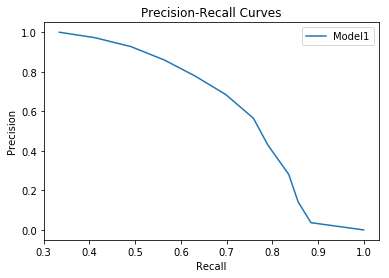

In [318]:
plt.plot(prec_n, rec_n, label = "Model1")
# plt.plot(prec2, rec2, label = "Model2")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.show()

In [319]:
y_pred_binary = final_model.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished


In [320]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred_binary)


array([[2275,  225],
       [ 546,  708]])

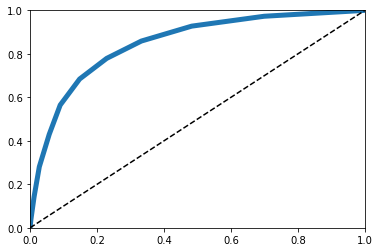

In [321]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=5, label=label)
    plt.plot([0, 1], [0,1], 'k--')
    plt.axis([0, 1, 0, 1])
    
plot_roc_curve(fpr, tpr)

# Anything below this is scratch work
### One option is to drop all rows containing any na

In [13]:
df_dropped_any = df_filtered_time.dropna()

In [14]:
df_dropped_any['label'].value_counts()

0    12897
1     3488
Name: label, dtype: int64

In [15]:
labels = df_dropped_any.pop('label').values
df_dropped_any = df_dropped_any.values

In [16]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=42)

for train_index, test_index in skf.split(df_dropped_any, labels):
    X_train, X_test = df_dropped_any[train_index],df_dropped_any[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.pipeline import Pipeline
num_pipeline = Pipeline([
    ('imputer', Imputer(strategy='median')),
    ('std_scalar', StandardScaler())
])
X_train = num_pipeline.fit_transform(X_train)
X_test = num_pipeline.transform(X_test)

/Users/chriszhou/anaconda/envs/py37/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [43]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)

In [44]:
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [49]:
y_pred = rnd_clf.predict_proba(X_test)[:, 1]

In [50]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

ValueError: Classification metrics can't handle a mix of binary and continuous targets

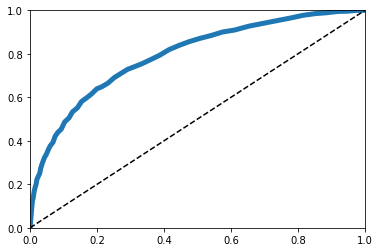

In [51]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=5, label=label)
    plt.plot([0, 1], [0,1], 'k--')
    plt.axis([0, 1, 0, 1])
    
plot_roc_curve(fpr, tpr)

In [52]:
prec1, rec1, thresholds1 = metrics.precision_recall_curve(y_test, y_pred)

### If we only drop urine and use median imputation

In [53]:
df_filtered_time.drop(columns=['Urine output_sum'], inplace=True)
labels = df_filtered_time.pop('label').values
df_filtered_time = df_filtered_time.values

AttributeError: 'numpy.ndarray' object has no attribute 'drop'

In [54]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=42)

for train_index, test_index in skf.split(df_filtered_time, labels):
    X_train, X_test = df_filtered_time[train_index],df_filtered_time[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

In [55]:
X_train = num_pipeline.fit_transform(X_train)
X_test = num_pipeline.transform(X_test)

In [56]:
y_pred = rnd_clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]

In [57]:
prec2, rec2, thresholds2 = metrics.precision_recall_curve(y_test, y_pred)

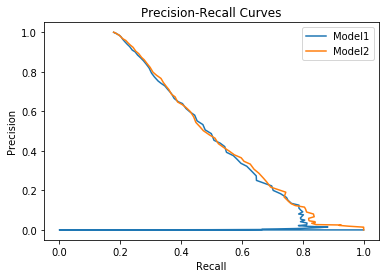

In [58]:
plt.plot(prec1, rec1, label = "Model1")
plt.plot(prec2, rec2, label = "Model2")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.show()

### SVM Ergang

In [60]:
X_train_prepped = prep_pipeline.fit_transform(X_train)
X_test_prepped = prep_pipeline.transform(X_test)

In [61]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
pipe_svc=make_pipeline(SVC(max_iter=5000, verbose=2, class_weight='balanced',random_state=1))
param_range = [0.0001,0.001,0.01,0.1,1,10,100,1000]
param_grid=[{'svc__C':param_range,'svc__kernel':['linear']},{'svc__C':param_range,
                        'svc__gamma':param_range,'svc__kernel':['rbf']}]
gs_svm = GridSearchCV(estimator=pipe_svc,param_grid=param_grid,scoring='f1',
                 cv=5,n_jobs=-1)
gs_svm=gs_svm.fit(X_train_prepped,y_train)
print(gs_svm.best_score_)
print(gs_svm.best_params_)

KeyboardInterrupt: 

In [ ]:
from sklearn.externals import joblib
filename = '/Users/ergangwang/Downloads/DSAH_Final/svm_optimized.sav'
svm_best = gs_svm.best_estimator_
joblib.dump(svm_best, filename)

### random forest Ergang

In [78]:
from sklearn.ensemble import RandomForestClassifier
pipe_rdf = make_pipeline(RandomForestClassifier(verbose=2,n_estimators=100,random_state=1,class_weight='balanced'))
param_grid = {"randomforestclassifier__max_depth": [3, None],
              "randomforestclassifier__max_features": [1, 3, 10],
              "randomforestclassifier__min_samples_split": [2, 3, 10],
              "randomforestclassifier__bootstrap": [True, False],
              "randomforestclassifier__criterion": ["gini", "entropy"]}
gs_rdf = GridSearchCV(pipe_rdf, param_grid=param_grid, scoring='f1',cv=5, n_jobs=-1)
gs_rdf=gs_rdf.fit(X_train_prepped, y_train)
print(gs_rdf.best_score_)
print(gs_rdf.best_params_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.6s finished


In [ ]:
filename = '/Users/ergangwang/Downloads/DSAH_Final/rdf_optimized.sav'
rdf_best = gs_rdf.best_estimator_
joblib.dump(rdf_best, filename)

In [70]:
pipe_rdf.get_params().keys()

dict_keys(['memory', 'steps', 'randomforestclassifier', 'randomforestclassifier__bootstrap', 'randomforestclassifier__class_weight', 'randomforestclassifier__criterion', 'randomforestclassifier__max_depth', 'randomforestclassifier__max_features', 'randomforestclassifier__max_leaf_nodes', 'randomforestclassifier__min_impurity_decrease', 'randomforestclassifier__min_impurity_split', 'randomforestclassifier__min_samples_leaf', 'randomforestclassifier__min_samples_split', 'randomforestclassifier__min_weight_fraction_leaf', 'randomforestclassifier__n_estimators', 'randomforestclassifier__n_jobs', 'randomforestclassifier__oob_score', 'randomforestclassifier__random_state', 'randomforestclassifier__verbose', 'randomforestclassifier__warm_start'])

### Neural network Ergang

### Adaboost Ergang

In [76]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "n_estimators": [1, 5, 10, 20],
              "learning_rate": [0.5,1,2],
              "base_estimator__max_depth": [3, None],
              "base_estimator__max_features": [1, 3, 10],
              "base_estimator__min_samples_split": [2, 3, 10]
             }


DTC = DecisionTreeClassifier(random_state = 1, max_features = "auto", class_weight = "balanced",max_depth = None)

ABC = AdaBoostClassifier(base_estimator = DTC)

# run grid search
gs_abc = GridSearchCV(ABC, param_grid=param_grid, scoring='f1',cv=5, n_jobs=-1)
gs_abc=gs_abc.fit(X_train_prepped, y_train)
print(gs_abc.best_score_)
print(gs_abc.best_params_)

In [ ]:
filename = '/Users/ergangwang/Downloads/DSAH_Final/abc_optimized.sav'
abc_best = gs_abc.best_estimator_
joblib.dump(abc_best, filename)

In [77]:
ABC.get_params().keys()

dict_keys(['algorithm', 'base_estimator__class_weight', 'base_estimator__criterion', 'base_estimator__max_depth', 'base_estimator__max_features', 'base_estimator__max_leaf_nodes', 'base_estimator__min_impurity_decrease', 'base_estimator__min_impurity_split', 'base_estimator__min_samples_leaf', 'base_estimator__min_samples_split', 'base_estimator__min_weight_fraction_leaf', 'base_estimator__presort', 'base_estimator__random_state', 'base_estimator__splitter', 'base_estimator', 'learning_rate', 'n_estimators', 'random_state'])

### SVM

In [59]:
from sklearn.svm import LinearSVC
svm = LinearSVC(class_weight='balanced', C=1.0, verbose=2, max_iter=5000)

In [61]:
svm.fit(X_train, y_train)

[LibLinear]

/Users/chriszhou/anaconda/envs/py37/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=5000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=2)

In [62]:
y_pred = svm.decision_function(X_test)
prec3, rec3, thresholds3 = metrics.precision_recall_curve(y_test, y_pred)

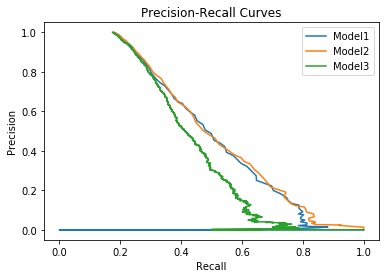

In [63]:
plt.plot(prec1, rec1, label = "Forest Drop all na")
plt.plot(prec2, rec2, label = "Forest impute median")
plt.plot(prec3, rec3, label = "SVM")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.show()

### Simple Neural Network

In [64]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.neural_network import MLPClassifier
cv = StratifiedKFold(n_splits = 4)

param_grid = {
    'hidden_layer_sizes': [(50,), (50, 50), (50, 50, 50), (100, 100)]
}

In [65]:
bst_grid = GridSearchCV(
    estimator = MLPClassifier(),
    param_grid = param_grid,
    cv = cv,
    scoring = 'f1', 
    verbose = 3,
    n_jobs = -1)
bst_grid.fit(X_train, y_train)

Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  16 | elapsed:   56.5s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:  1.7min remaining:   23.2s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  1.8min finished


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
       error_score='raise-deprecating',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'hidden_layer_sizes': [(50,), (50, 50), (50, 50, 50), (100, 100)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=3)

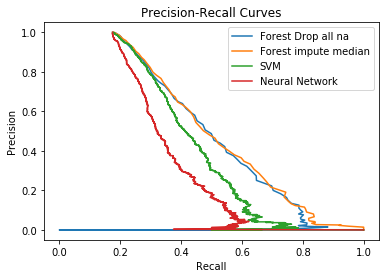

In [66]:
y_pred = bst_grid.best_estimator_.predict_proba(X_test)[:,1]
prec4, rec4, thresholds4 = metrics.precision_recall_curve(y_test, y_pred)
plt.plot(prec1, rec1, label = "Forest Drop all na")
plt.plot(prec2, rec2, label = "Forest impute median")
plt.plot(prec3, rec3, label = "SVM")
plt.plot(prec4, rec4, label = "Neural Network")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.show()


### Adaboost

In [74]:
from sklearn.ensemble import AdaBoostClassifier
rnd_clf = RandomForestClassifier(n_estimators=50, n_jobs=-1)
ada_clf = AdaBoostClassifier(learning_rate=.5)

In [75]:
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.5, n_estimators=50, random_state=None)

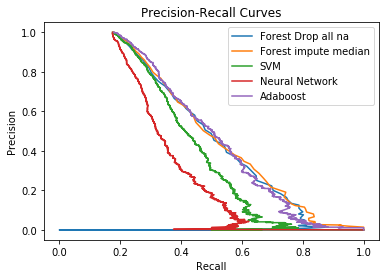

In [76]:
y_pred = ada_clf.predict_proba(X_test)[:, 1]
prec5, rec5, thresholds5 = metrics.precision_recall_curve(y_test, y_pred)
plt.plot(prec1, rec1, label = "Forest Drop all na")
plt.plot(prec2, rec2, label = "Forest impute median")
plt.plot(prec3, rec3, label = "SVM")
plt.plot(prec4, rec4, label = "Neural Network")
plt.plot(prec5, rec5, label = "Adaboost")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.show()

### Removed Abnormal Labs

In [77]:
df_filtered_time_only_abnormal_sum.drop(columns=['Urine output_sum'], inplace=True)
labels = df_filtered_time_only_abnormal_sum.pop('label').values
df_filtered_time_only_abnormal_sum = df_filtered_time_only_abnormal_sum.values

In [78]:
for train_index, test_index in skf.split(df_filtered_time, labels):
    X_train, X_test = df_filtered_time_only_abnormal_sum[train_index],df_filtered_time_only_abnormal_sum[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

In [79]:
X_train = num_pipeline.fit_transform(X_train)
X_test = num_pipeline.transform(X_test)
y_pred = rnd_clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]

In [80]:
prec7, rec7, thresholds7 = metrics.precision_recall_curve(y_test, y_pred)

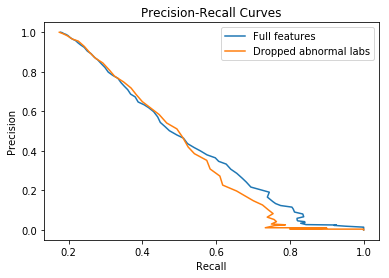

In [81]:
plt.plot(prec2, rec2, label = "Full features")
plt.plot(prec7, rec7, label = "Dropped abnormal labs")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.show()

In [82]:
X_train.shape

(23013, 71)

### ensemble

/Users/ergangwang/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `comb` is deprecated!
Importing `comb` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.comb` instead.
  import sys


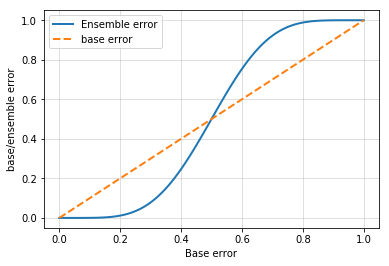

In [21]:
#ensemble is always better than just one classifier as long as the base classifier perform better than random guessing
from scipy.misc import comb
import math
def ensemble_error(n_classifier,error):
    k_start = int(math.ceil(n_classifier/2))
    probs=[comb(n_classifier,k) * error**k*
           (1-error)**(n_classifier - k)
           for k in range(k_start, n_classifier +1)]
    return sum(probs)
error_range = np.arange(0,1.01,0.01)
ens_errors = [ensemble_error(n_classifier=11, error=error) for error in error_range]
plt.plot(error_range,ens_errors,label="Ensemble error",linewidth=2)
plt.plot(error_range,error_range,linestyle='--',label='base error',linewidth=2)
plt.xlabel('Base error')
plt.ylabel('base/ensemble error')
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.show()

In [22]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator


class MajorityVoteClassifier(BaseEstimator, 
                             ClassifierMixin):
    """ A majority vote ensemble classifier

    Parameters
    ----------
    classifiers : array-like, shape = [n_classifiers]
      Different classifiers for the ensemble

    vote : str, {'classlabel', 'probability'} (default='label')
      If 'classlabel' the prediction is based on the argmax of
        class labels. Else if 'probability', the argmax of
        the sum of probabilities is used to predict the class label
        (recommended for calibrated classifiers).

    weights : array-like, shape = [n_classifiers], optional (default=None)
      If a list of `int` or `float` values are provided, the classifiers
      are weighted by importance; Uses uniform weights if `weights=None`.

    """
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """ Fit classifiers.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Matrix of training samples.

        y : array-like, shape = [n_samples]
            Vector of target class labels.

        Returns
        -------
        self : object

        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote must be 'probability' or 'classlabel'"
                             "; got (vote=%r)"
                             % self.vote)

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('Number of classifiers and weights must be equal'
                             '; got %d weights, %d classifiers'
                             % (len(self.weights), len(self.classifiers)))

        # Use LabelEncoder to ensure class labels start with 0, which
        # is important for np.argmax call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """ Predict class labels for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Matrix of training samples.

        Returns
        ----------
        maj_vote : array-like, shape = [n_samples]
            Predicted class labels.
            
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote

            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T
            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """ Predict class probabilities for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.

        Returns
        ----------
        avg_proba : array-like, shape = [n_samples, n_classes]
            Weighted average probability for each class per sample.

        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """ Get classifier parameter names for GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out


In [23]:
# using the majority voting principle to make predicitons
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test =\
       train_test_split(X, y, 
                        test_size=0.5, 
                        random_state=1,
                        stratify=y)


In [24]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

clf1 = LogisticRegression(penalty='l2', 
                          C=0.001,
                          random_state=1)

clf2 = DecisionTreeClassifier(max_depth=1,
                              criterion='entropy',
                              random_state=0)

clf3 = KNeighborsClassifier(n_neighbors=1,
                            p=2,
                            metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])

clf_labels = ['Logistic regression', 'Decision tree', 'KNN']

print('10-fold cross validation:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

10-fold cross validation:

ROC AUC: 0.87 (+/- 0.17) [Logistic regression]
ROC AUC: 0.89 (+/- 0.16) [Decision tree]
ROC AUC: 0.88 (+/- 0.15) [KNN]


/Users/ergangwang/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ergangwang/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ergangwang/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ergangwang/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ergangwang/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/lo

In [25]:
# Majority Rule (hard) Voting

mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])

clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

ROC AUC: 0.87 (+/- 0.17) [Logistic regression]
ROC AUC: 0.89 (+/- 0.16) [Decision tree]
ROC AUC: 0.88 (+/- 0.15) [KNN]
ROC AUC: 0.94 (+/- 0.13) [Majority voting]


/Users/ergangwang/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ergangwang/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ergangwang/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ergangwang/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ergangwang/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/lo

### evaluate and tunign the ensemble classifier

/Users/ergangwang/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ergangwang/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


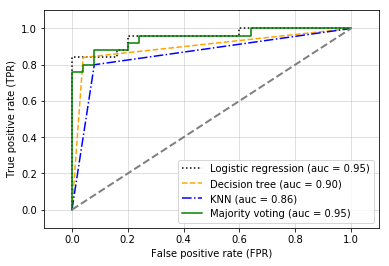

In [27]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls \
        in zip(all_clf,
               clf_labels, colors, linestyles):

    # assuming the label of the positive class is 1
    y_pred = clf.fit(X_train,
                     y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
             color=clr,
             linestyle=ls,
             label='%s (auc = %0.2f)' % (label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')


#plt.savefig('images/07_04', dpi=300)
plt.show()

/Users/ergangwang/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ergangwang/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


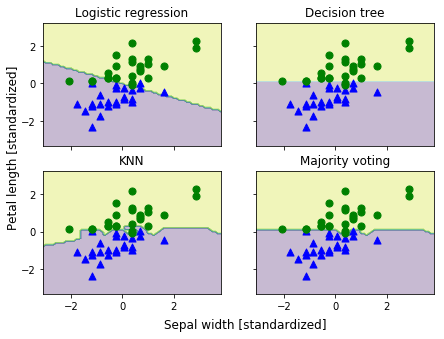

In [29]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
from itertools import product

all_clf = [pipe1, clf2, pipe3, mv_clf]

x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=2, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(7, 5))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0], 
                                  X_train_std[y_train==0, 1], 
                                  c='blue', 
                                  marker='^',
                                  s=50)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0], 
                                  X_train_std[y_train==1, 1], 
                                  c='green', 
                                  marker='o',
                                  s=50)
    
    axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -5., 
         s='Sepal width [standardized]', 
         ha='center', va='center', fontsize=12)
plt.text(-12.5, 4.5, s='Petal length [standardized]', 
         ha='center', va='center', 
         fontsize=12, rotation=90)

#plt.savefig('images/07_05', dpi=300)
plt.show()

In [30]:
mv_clf.get_params()

{'decisiontreeclassifier': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=0,
             splitter='best'),
 'decisiontreeclassifier__class_weight': None,
 'decisiontreeclassifier__criterion': 'entropy',
 'decisiontreeclassifier__max_depth': 1,
 'decisiontreeclassifier__max_features': None,
 'decisiontreeclassifier__max_leaf_nodes': None,
 'decisiontreeclassifier__min_impurity_decrease': 0.0,
 'decisiontreeclassifier__min_impurity_split': None,
 'decisiontreeclassifier__min_samples_leaf': 1,
 'decisiontreeclassifier__min_samples_split': 2,
 'decisiontreeclassifier__min_weight_fraction_leaf': 0.0,
 'decisiontreeclassifier__presort': False,
 'decisiontreeclassifier__random_state': 0,
 'decisiontreeclassifier__splitter': 

In [31]:
from sklearn.model_selection import GridSearchCV

params = {'decisiontreeclassifier__max_depth': [1, 2],
          'pipeline-1__clf__C': [0.001, 0.1, 100.0]}

grid = GridSearchCV(estimator=mv_clf,
                    param_grid=params,
                    cv=10,
                    scoring='roc_auc')
grid.fit(X_train, y_train)

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_['mean_test_score'][r], 
             grid.cv_results_['std_test_score'][r] / 2.0, 
             grid.cv_results_['params'][r]))

/Users/ergangwang/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ergangwang/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ergangwang/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ergangwang/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ergangwang/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/lo

0.933 +/- 0.07 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.947 +/- 0.07 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.973 +/- 0.04 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.947 +/- 0.07 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.947 +/- 0.07 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.973 +/- 0.04 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


/Users/ergangwang/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ergangwang/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ergangwang/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ergangwang/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ergangwang/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/lo

In [32]:
print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)

Best parameters: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
Accuracy: 0.97


In [33]:
grid.best_estimator_.classifiers


[Pipeline(memory=None,
      steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ['clf', LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='warn',
           n_jobs=None, penalty='l2', random_state=1, solver='warn',
           tol=0.0001, verbose=0, warm_start=False)]]),
 DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=0,
             splitter='best'),
 Pipeline(memory=None,
      steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ['clf', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=None, n_neighbors=1, p=2,
            weight

In [34]:
mv_clf = grid.best_estimator_

In [35]:
mv_clf.set_params(**grid.best_estimator_.get_params())


MajorityVoteClassifier(classifiers=[Pipeline(memory=None,
     steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2'...',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform'))])],
            vote='classlabel', weights=None)

In [36]:
mv_clf


MajorityVoteClassifier(classifiers=[Pipeline(memory=None,
     steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2'...',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform'))])],
            vote='classlabel', weights=None)